In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
device ='cuda'

In [5]:
MODULUS= 31
HIDDEN_DIM = 100

In [6]:
#The following generates a random batch from the distrubition
def generate_batch_modular_arithmetic(batch_size=64, modulus=31):
    X = torch.randint(high=30, size=(batch_size, 2))
    y = X.sum(1) % 31
    X = F.one_hot(X, num_classes=modulus).view(batch_size, 2*modulus)
    X = X.to(torch.float)
    y = F.one_hot(y, num_classes=modulus)
    y = y.to(torch.float)
    return X,y

In [7]:
#However grokking is a specific test/train phenomena
#So I need to work out how to generate the entire dataset

In [8]:
def generate_entire_dataset(modulus):
    A = torch.arange(modulus)
    B = torch.arange(modulus)
    A_B = torch.cartesian_prod(A,B)
    C = A_B.sum(1) % modulus

    X = F.one_hot(A_B).to(torch.float).view(modulus**2,2*modulus)
    Y = F.one_hot(C)
    X = X.to(torch.float)
    Y = Y.to(torch.float)
    return X, Y

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dimension = hidden_dim
        self.output_dim = output_dim
        
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        x = self.linear_layers(x)
        return x

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
def calculate_accuracy(y_pred, y):
    acc = y_pred.argmax(1).eq(y.argmax(1)).to(torch.float).mean()
    return acc

In [45]:
def train_from_batches(model, optimiser, N_EPOCHS, criterion, device):
    losses = []
    model = model.to(device)
    criterion = criterion.to(device)
    model.train()
    for i in range(N_EPOCHS):
        X,y = generate_batch_modular_arithmetic(64, MODULUS)
        X,y = X.to(device), y.to(device)
        optimiser.zero_grad()
        y_pred = model(X)
        
        loss = criterion(y_pred, y)
        loss.backward()
        optimiser.step()
        
        if i % 50 == 0:
            print(i, loss.item())
        losses.append(loss.item())
    return losses

In [31]:
def train(model, train_set, test_set, N_EPOCHS, device='cuda'):
    losses = []
    train_acc = []
    test_acc = []
    
    model = model.to(device)
    optimiser = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.2)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    model.train()
    X_train, y_train = train_set[0], train_set[1]
    X_test, y_test = test_set[0], test_set[1]
    X_test, y_test = X_test.to(device), y_test.to(device)
    train_size = len(X_train)
    for i in range(N_EPOCHS):
        model.train()
        idx = torch.randperm(train_size)[:64]
        X,y = X_train[idx], y_train[idx]
        X,y = X.to(device), y.to(device)
        optimiser.zero_grad()
        y_pred = model(X)
        
        loss = criterion(y_pred, y)
        accuracy = calculate_accuracy(y_pred, y)
        loss.backward()
        optimiser.step()
        # print(y_pred.shape, y.shape)
        
        if i % 50 == 0:
            print(i, loss.item(), accuracy.item())

        losses.append(loss.item())
        train_acc.append(accuracy.item())
        with torch.inference_mode():
            model.eval()
            test_preds = model(X_test)
            test_accuracy = calculate_accuracy(test_preds, y_test)
            test_acc.append(test_accuracy.item())
    return losses, train_acc, test_acc

In [24]:
X_full,y_full = generate_entire_dataset(MODULUS)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [34]:
model = MLP(2*MODULUS, HIDDEN_DIM, MODULUS)

In [35]:
losses, train_acc, test_acc = train(model, (X_train, y_train), (X_test, y_test), 20000)

0 3.44781494140625 0.015625
50 3.415618419647217 0.046875
100 3.4073486328125 0.046875
150 3.403024673461914 0.046875
200 3.3170523643493652 0.0625
250 3.1300435066223145 0.140625
300 2.894505500793457 0.234375
350 2.5184597969055176 0.25
400 1.846604347229004 0.546875
450 1.4068090915679932 0.640625
500 1.0696282386779785 0.734375
550 0.8121851682662964 0.796875
600 0.5993212461471558 0.90625
650 0.35992538928985596 0.96875
700 0.2655182480812073 0.984375
750 0.2729094922542572 0.96875
800 0.1717938929796219 0.984375
850 0.09832128882408142 1.0
900 0.09670752286911011 1.0
950 0.11366666853427887 1.0
1000 0.06705756485462189 1.0
1050 0.05644912272691727 1.0
1100 0.05634228512644768 1.0
1150 0.045604899525642395 1.0
1200 0.04146353155374527 1.0
1250 0.03909550607204437 1.0
1300 0.04243016242980957 1.0
1350 0.03680162504315376 1.0
1400 0.024010926485061646 1.0
1450 0.02497725374996662 1.0
1500 0.02900351956486702 1.0
1550 0.030284389853477478 1.0
1600 0.022419173270463943 1.0
1650 0.0230

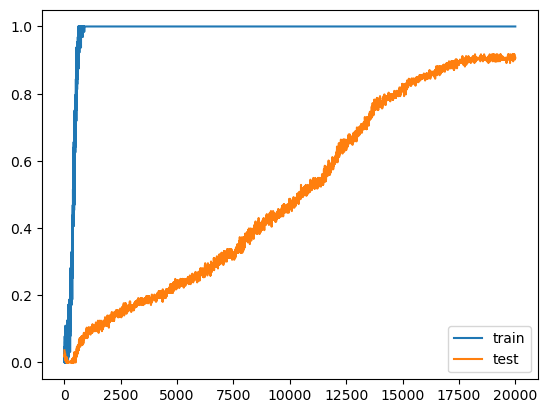

In [36]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()

In [84]:
def calculate_sample_r2(Y, lambdas):
    #Y (d,N)
    #lambdas (N,1)
    d,N = Y.shape
    
    Y_Lambda = 1/N * Y @ lambdas 

    Exp_Y =  Y.mean(1)
    Exp_Ysq = (Y**2).mean(1)
    
    
    numerator =  Y_Lambda - 0.5 * Exp_Y
    denominator = (Exp_Ysq - Exp_Y**2) * lambdas.var(correction=0)
    return numerator**2 / denominator

In [52]:
Y= torch.randn(5,10)
lambdas = torch.linspace(start=0,end=1,steps=10)

In [78]:
calculate_sample_r2(Y, lambdas)

tensor([0.0193, 0.1623, 0.0587, 0.0010, 0.0094])

In [79]:
A = torch.zeros(5)
B = torch.ones(5)

In [80]:
X = torch.zeros(5,10)
for i in range(10):
    X[:,i] = A + lambdas[i] * (B - A)

In [85]:
X

tensor([[0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000]])

In [86]:
calculate_sample_r2(X, lambdas)

tensor([1., 1., 1., 1., 1.])

In [113]:
def calculate_L_specific(method, first_data, second_data, N=21):
    model.eval()
    d = first_data.shape[-1]
    assert second_data.shape[-1] == d
    #Assume method takes (*,d) -> (*,D)
    X = torch.zeros(N,d) #Will hold the pathway
    lambdas = torch.linspace(0,1,steps=21).to(device)
    for i in range(N):
        X[i,:] = first_data + lambdas[i] * (second_data - first_data)
    X = X.to(device)
    with torch.inference_mode():
        Y = method(X) #(N,d)
    Y = Y.T #(d,N)
    vec_r2 = calculate_sample_r2(Y, lambdas)
    return vec_r2.mean()

In [114]:
X_full = X_full.to(device)
calculate_L_specific(model, X_full[0], X_full[1])

tensor(0.9315, device='cuda:0')

In [122]:
L = torch.zeros(5,5).fill_diagonal_(1)

In [123]:
L

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

In [155]:
def calculate_L_full(method, X_data, num_samples=21):
    N = X_data.shape[0]
    L = torch.zeros((N,N)).fill_diagonal_(0.5)
    for i in range(N):
        # print(i)
        for j in range(i):
            first_data, second_data = X_data[i], X_data[j]
            Lij = calculate_L_specific(method, first_data, second_data, num_samples)
            L[i,j] = Lij
    L += L.clone().T
    return L

In [157]:
%%timeit
L = calculate_L_full(model, X_test.to(device)[:50])

1.41 s ± 80.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [151]:
def calculate_SNL(L):
    evals = torch.linalg.eigh(L)[0]
    evals_tilde = evals.abs()/evals.abs().sum()
    SNL = -(evals_tilde * torch.log2(evals_tilde)).sum()
    return SNL